In [1]:
# import neural_process as nep
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline

Sizes
  x: (80, 1) 
  y: (80, 1) 
for each task


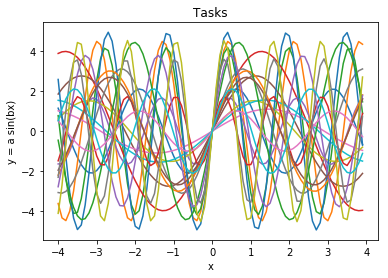

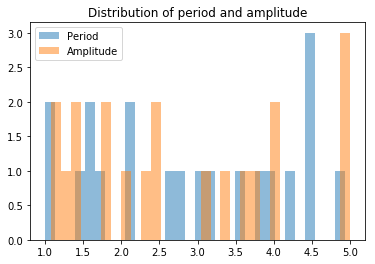

In [2]:
datasets = {}
n_tasks = 20
period = []
amplitude = []
x_np = np.arange(-4, 4, 0.1).reshape(-1, 1).astype(np.float32)

#plt.subplot(3,1,1)
for i in range(n_tasks):
    a = np.random.uniform(1, 5)
    period.append(a)
    b = np.random.uniform(1, 5)
    amplitude.append(b)
    y_np = a * np.sin(b * x_np)
    datasets['task_{}'.format(i)] = y_np 
    plt.plot(x_np, y_np)
plt.title('Tasks')
plt.ylabel('y = a sin(bx)')
plt.xlabel('x')
print('Sizes\n', ' x:', x_np.shape, '\n  y:', y_np.shape, '\nfor each task')
plt.show()

#plt.subplot(3,1,2)
plt.hist(period, 30, alpha=0.5)
plt.hist(amplitude, 30, alpha=0.5)
plt.legend(['Period', 'Amplitude'])
plt.title('Distribution of period and amplitude')
plt.show()

In [3]:
x_dim = 1
y_dim = 1
r_dim = 5
z_dim = 5
encoder_specs = [(8, torch.nn.ReLU()), (r_dim, None)]
decoder_specs = [(12, torch.nn.ReLU()), (1, None)]
init_func = torch.nn.init.normal_

In [4]:
x_c = torch.from_numpy(x_np)
y_c = torch.from_numpy(y_np)
x_t = torch.from_numpy(x_np)
y_t = torch.from_numpy(y_np)

In [56]:
import torch
import numpy as np


class NP(torch.nn.Module):
    def __init__(self, x_dim, y_dim, r_dim, z_dim, encoder_specs, decoder_specs, init_func):
        super().__init__()
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.r_dim = r_dim
        self.z_dim = z_dim
        self.encoder_specs = encoder_specs
        self.decoder_specs = decoder_specs
        self.init_func = init_func
        self.softplus_act = torch.nn.Softplus()
        self.r_to_z_mean = torch.nn.Linear(self.r_dim, self.z_dim)
        self.r_to_z_logvar = torch.nn.Linear(self.r_dim, self.z_dim)

        
        # Create the encoder
        for i in range(len(self.encoder_specs)):
            if i == 0:    
                encoder_input_dim = self.x_dim + self.y_dim
                self.add_module('h_layer' + str(i), \
                        torch.nn.Linear(encoder_input_dim, self.encoder_specs[i][0]))

                if self.encoder_specs[i][1]:
                    self.add_module('h_layer' + str(i) + '_act', self.encoder_specs[i][1])

            else:
                self.add_module('h_layer' + str(i), \
                        torch.nn.Linear(self.encoder_specs[i-1][0], self.encoder_specs[i][0]))

                if self.encoder_specs[i][1]:
                    self.add_module('h_layer' + str(i) + '_act', self.encoder_specs[i][1]) 

        # Create the decoder
        for i in range(len(self.decoder_specs)):
            if i == 0:    
                decoder_input_dim = self.x_dim + self.z_dim
                self.add_module('g_layer' + str(i), \
                    torch.nn.Linear(decoder_input_dim, self.decoder_specs[i][0]))

                if self.decoder_specs[i][1]:
                    self.add_module('g_layer' + str(i) + '_act', self.decoder_specs[i][1])

            else:
                self.add_module('g_layer' + str(i), \
                    torch.nn.Linear(self.decoder_specs[i-1][0], self.decoder_specs[i][0]))

                if self.decoder_specs[i][1]:
                    self.add_module('g_layer' + str(i) + '_act', self.decoder_specs[i][1]) 
        
        if init_func:
            for layer_name,_ in self._modules.items():
                if layer_name.endswith('act') == False:
                    init_func(getattr(getattr(self, layer_name), 'weight'))
        


    def h(self, x, y):
        x_y = torch.cat([x, y], dim=1)
        for layer_name, layer_func in self._modules.items():
            if layer_name.startswith('h'):
                x_y = layer_func(x_y)
        return x_y



    def aggregate(self, r):
        return torch.mean(r, dim=0)



    def xy_to_z_params(self, x, y):
        r = self.h(x, y)
        r = self.aggregate(r)

        mean = self.r_to_z_mean(r)
        logvar = self.r_to_z_logvar(r)

        return mean.unsqueeze(-1), logvar.unsqueeze(-1)
       


    def sample_z(self, z, how_many):
        """
        Returns a sample from z of size (z_dim, how_many)
        """
        mean, logvar = z
        std = torch.exp(0.5 * logvar)

        eps = torch.randn([self.z_dim, how_many])
        z_samples = mean + std * eps
        return z_samples



    def g(self, x, z):
        z_reshape =  z.t().unsqueeze(1).expand(-1, x.shape[0], -1)
        x_reshape = x.unsqueeze(0).expand(z_reshape.shape[0], x.shape[0], x.shape[1])
        x_z = torch.cat([x_reshape, z_reshape], dim=2)

        y_mean = x_z
        for layer_name, layer_func in self._modules.items():
            if layer_name.startswith('g'):
                y_mean = layer_func(y_mean)

        return y_mean
    


    def forward(self, x_context, y_context, x_target, y_target):
        z_context = self.xy_to_z_params(x_context, y_context)
        print(self.training)
        if self.training:
            z_target = self.xy_to_z_params(x_target, y_target)
        else:
            z_target = z_context

        z_sample = self.sample_z(z_target, how_many=1)
        y_hat = self.g(x_target, z_sample)

        return y_hat, z_target, z_context
    
    
    
def KL_div(mu_q, logvar_q, mu_p, logvar_p):
    KL = (torch.exp(logvar_q) + (mu_q - mu_p) ** 2) / torch.exp(logvar_p) \
             - 1.0 \
             + logvar_p - logvar_q
    KL = 0.5 * KL.sum()
    return KL


def ELBO(y_hat, y, z_target, z_context):
    log_lik = torch.nn.functional.mse_loss(y_hat, y)
    KL = KL_div(z_target[0], z_target[1], z_context[0], z_context[1])
    return - log_lik + KL

In [57]:
model = NP(x_dim, y_dim, r_dim, z_dim, encoder_specs, decoder_specs, init_func)

In [58]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [51]:
model.train()

NP(
  (softplus_act): Softplus(beta=1, threshold=20)
  (r_to_z_mean): Linear(in_features=5, out_features=5, bias=True)
  (r_to_z_logvar): Linear(in_features=5, out_features=5, bias=True)
  (h_layer0): Linear(in_features=2, out_features=8, bias=True)
  (h_layer0_act): ReLU()
  (h_layer1): Linear(in_features=8, out_features=5, bias=True)
  (g_layer0): Linear(in_features=6, out_features=12, bias=True)
  (g_layer0_act): ReLU()
  (g_layer1): Linear(in_features=12, out_features=1, bias=True)
)

In [59]:
y_hat, z_t, z_c = model(x_c,y_c,x_t,y_t)

True
(tensor([[ -6.0711],
        [-10.6357],
        [ -7.0518],
        [  1.6809],
        [ -5.1114]], grad_fn=<UnsqueezeBackward0>), tensor([[ 4.1042],
        [-1.6603],
        [ 5.5920],
        [-7.2933],
        [ 4.8810]], grad_fn=<UnsqueezeBackward0>)) (tensor([[ -6.0711],
        [-10.6357],
        [ -7.0518],
        [  1.6809],
        [ -5.1114]], grad_fn=<UnsqueezeBackward0>), tensor([[ 4.1042],
        [-1.6603],
        [ 5.5920],
        [-7.2933],
        [ 4.8810]], grad_fn=<UnsqueezeBackward0>))


In [63]:
z_t[0], z_c[0]

(tensor([[ -6.0711],
         [-10.6357],
         [ -7.0518],
         [  1.6809],
         [ -5.1114]], grad_fn=<UnsqueezeBackward0>), tensor([[ -6.0711],
         [-10.6357],
         [ -7.0518],
         [  1.6809],
         [ -5.1114]], grad_fn=<UnsqueezeBackward0>))

In [47]:
ELBO(y_hat, y_t, z_t, z_c)

tensor(-367.3962, grad_fn=<AddBackward0>)

In [48]:
z_t[0] - z_c[0]

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]], grad_fn=<SubBackward0>)

In [9]:
z_sample.shape, z[0].shape, z[1].shape

AttributeError: 'tuple' object has no attribute 'shape'

In [162]:
z_mod = z_sample.t().unsqueeze(1).expand(-1, x_c.shape[0], -1)
x_mod = x_c.unsqueeze(0).expand(z_mod.shape[0], x_c.shape[0], x_c.shape[1])

y = torch.cat([x_mod, z_mod], dim=2)
z_mod.shape, x_mod.shape, y.squeeze(-1).shape

(torch.Size([1, 80, 5]), torch.Size([1, 80, 1]), torch.Size([1, 80, 6]))

In [163]:
for layer_name, layer_func in model._modules.items():
    if layer_name.startswith('g'):
        y = layer_func(y)
